In [1]:
# Install required libraries
!pip install transformers datasets torch torchvision scikit-learn matplotlib seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 45.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 37.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 35.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 93.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
# Import libraries
import torch
import torchvision
from transformers import ViTImageProcessor, ViTForImageClassification
from datasets import load_dataset
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
from sklearn.metrics import classification_report
from google.colab import files
from PIL import Image
import io

In [3]:
# Mount Google Drive
drive.mount('/content/drive')

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Mounted at /content/drive
Using device: cuda


In [4]:
# Define path to your dataset in Google Drive
dataset_path = "/content/drive/MyDrive/sunflower_dataset/"  # Update this path

# Load dataset from folder (assumes subfolders: Gray Mold, Downy Mildew, Leaf Scars, Fresh Leaves)
dataset = load_dataset("imagefolder", data_dir=dataset_path, split="train")

# Split into 70% train, 15% validation, 15% test
dataset = dataset.train_test_split(test_size=0.3, seed=42)  # First split into train and test (30%)
train_dataset = dataset["train"]
remaining_dataset = dataset["test"]
validation_dataset = remaining_dataset.train_test_split(test_size=0.5, seed=42)["train"]  # Split the remaining 50% to 15% validation
test_dataset = remaining_dataset.train_test_split(test_size=0.5, seed=42)["test"]  # Split the remaining 50% to 15% test


Resolving data files:   0%|          | 0/1892 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

In [5]:
# Load the pre-trained ViT processor
processor = ViTImageProcessor.from_pretrained("google/vit-base-patch16-224")

# Preprocess function for images
def preprocess(examples):
    inputs = processor(images=examples["image"], return_tensors="pt", padding=True, truncation=True, size=(224, 224))
    examples["pixel_values"] = inputs["pixel_values"]
    return examples

# Apply preprocessing to datasets
train_dataset = train_dataset.map(preprocess, batched=True)
validation_dataset = validation_dataset.map(preprocess, batched=True)
test_dataset = test_dataset.map(preprocess, batched=True)

# Set format for PyTorch
train_dataset.set_format("torch", columns=["pixel_values", "label"])
validation_dataset.set_format("torch", columns=["pixel_values", "label"])
test_dataset.set_format("torch", columns=["pixel_values", "label"])

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2)
validation_loader = DataLoader(validation_dataset, batch_size=16, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=2)

# Define class names
class_names = ["downy mildew", "fresh leaf", "gray mold", "leaf scars"]
print("Dataset loaded and preprocessed successfully!")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

Map:   0%|          | 0/1324 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/transformers/image_processing_utils.py:42: UserWarning: The following named arguments are not valid for `ViTImageProcessor.preprocess` and were ignored: 'padding', 'truncation'
  return self.preprocess(images, **kwargs)


Map:   0%|          | 0/284 [00:00<?, ? examples/s]

Map:   0%|          | 0/284 [00:00<?, ? examples/s]

Dataset loaded and preprocessed successfully!


In [6]:
# Load pre-trained ViT model
model = ViTForImageClassification.from_pretrained("google/vit-base-patch16-224")

# Adjust classifier for 4 classes
model.classifier = torch.nn.Linear(model.classifier.in_features, 4)

# Move model to GPU
model.to(device)

print("Model loaded and moved to GPU!")

config.json:   0%|          | 0.00/69.7k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Model loaded and moved to GPU!


In [16]:
# Define optimizer and loss function
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)
loss_fn = torch.nn.CrossEntropyLoss()

# Initialize lists to store metrics for plotting later
train_accuracies = []
val_accuracies = []
test_accuracies = []

# Training loop
num_epochs = 1
model.train()

for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")
    running_loss = 0.0
    correct_train_predictions = 0
    total_train_predictions = 0

    for batch in train_loader:
        pixel_values = batch["pixel_values"].to(device)
        labels = batch["label"].to(device)

        # Forward pass
        outputs = model(pixel_values=pixel_values)
        loss = loss_fn(outputs.logits, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Calculate training accuracy
        _, preds = torch.max(outputs.logits, 1)
        correct_train_predictions += (preds == labels).sum().item()
        total_train_predictions += labels.size(0)

    avg_loss = running_loss / len(train_loader)
    train_accuracy = correct_train_predictions / total_train_predictions * 100
    train_accuracies.append(train_accuracy)

    print(f"Train Loss: {avg_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%")

    # Validation accuracy
    # Moved outside the training loop to be calculated once per epoch
    model.eval()
    correct_val_predictions = 0
    total_val_predictions = 0
    with torch.no_grad():
        for batch in validation_loader:
            pixel_values = batch["pixel_values"].to(device)
            labels = batch["label"].to(device)

            outputs = model(pixel_values=pixel_values)
            _, preds = torch.max(outputs.logits, 1)

            correct_val_predictions += (preds == labels).sum().item()
            total_val_predictions += labels.size(0)

    val_accuracy = correct_val_predictions / total_val_predictions * 100
    val_accuracies.append(val_accuracy)

    print(f"Validation Accuracy: {val_accuracy:.2f}%")


    # Test accuracy
    correct_test_predictions = 0
    total_test_predictions = 0
    with torch.no_grad():
        for batch in test_loader:
            pixel_values = batch["pixel_values"].to(device)
            labels = batch["label"].to(device)

            outputs = model(pixel_values=pixel_values)
            _, preds = torch.max(outputs.logits, 1)

            correct_test_predictions += (preds == labels).sum().item()
            total_test_predictions += labels.size(0)

    test_accuracy = correct_test_predictions / total_test_predictions * 100
    test_accuracies.append(test_accuracy)

    print(f"Test Accuracy: {test_accuracy:.2f}%")

print("Training completed!")

Epoch 1/1
Train Loss: 0.0170, Train Accuracy: 99.62%
Validation Accuracy: 94.72%
Test Accuracy: 96.48%
Training completed!


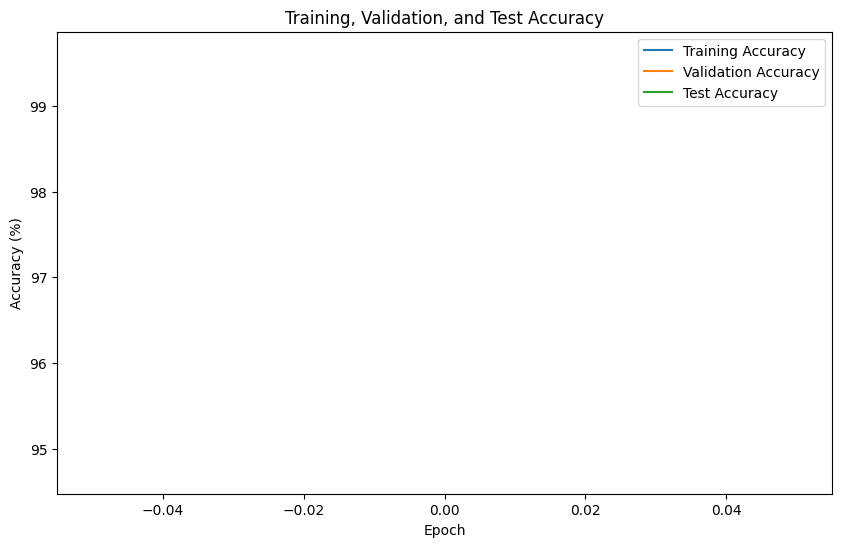

In [17]:
# Plot accuracies for training, validation, and test
plt.figure(figsize=(10, 6))
plt.plot(range(num_epochs), train_accuracies, label='Training Accuracy')
plt.plot(range(num_epochs), val_accuracies, label='Validation Accuracy')
plt.plot(range(num_epochs), test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training, Validation, and Test Accuracy')
plt.legend()
plt.show()

In [18]:
# Evaluate on test dataset and show precision, recall, F1-Score
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for batch in test_loader:
        pixel_values = batch["pixel_values"].to(device)
        labels = batch["label"].to(device)

        outputs = model(pixel_values=pixel_values)
        preds = torch.argmax(outputs.logits, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

Overall Metrics:
Accuracy: 0.9648
Precision: 0.9692
Recall: 0.9648
F1-Score: 0.9649


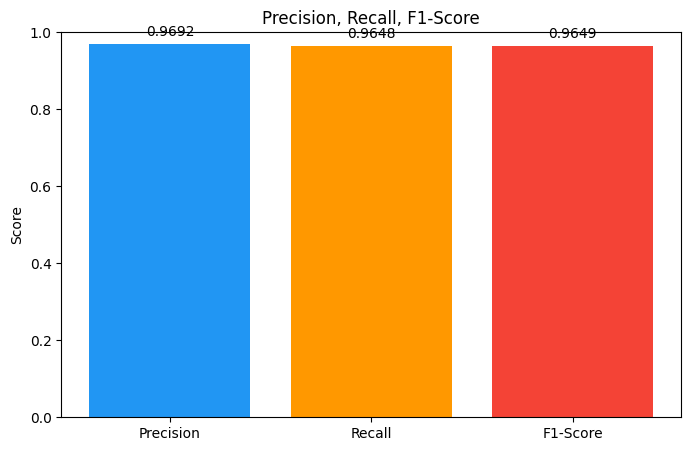

In [19]:
# Compute overall metrics
accuracy = accuracy_score(all_labels, all_preds)
precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average="weighted")

print("Overall Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

# Plot: Precision, Recall, F1-Score Bar Plot
metrics = {"Precision": precision, "Recall": recall, "F1-Score": f1}
plt.figure(figsize=(8, 5))
plt.bar(metrics.keys(), metrics.values(), color=["#2196F3", "#FF9800", "#F44336"])
plt.ylim(0, 1)
plt.title("Precision, Recall, F1-Score")
plt.ylabel("Score")
for i, v in enumerate(metrics.values()):
    plt.text(i, v + 0.02, f"{v:.4f}", ha="center")
plt.show()

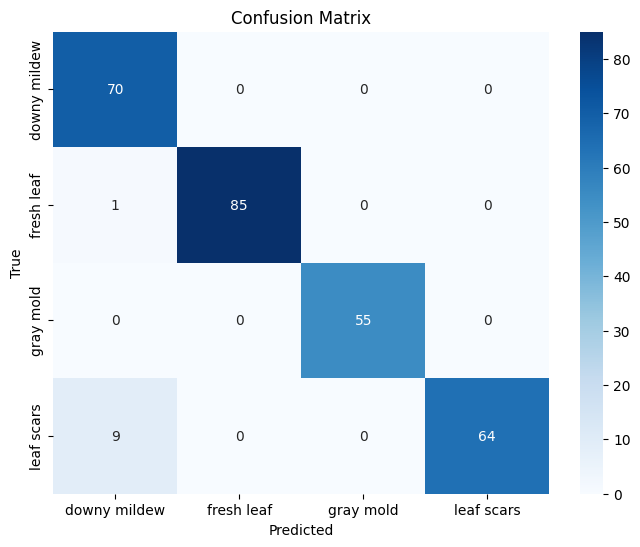

In [20]:
# Plot Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


Saving FreshLeaf (16).png to FreshLeaf (16).png
The uploaded image FreshLeaf (16).png is predicted as: fresh leaf


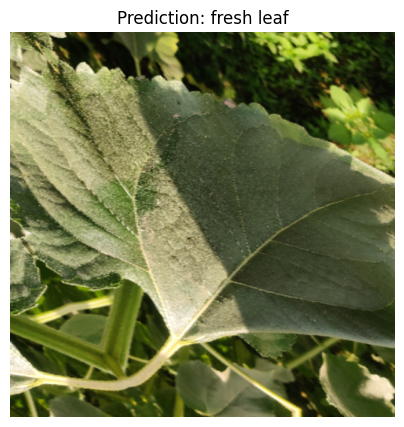

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [33]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, accuracy_score
from PIL import Image
import io

# Function to classify a single image
def classify_image(image):
    image = Image.open(image).convert("RGB")
    image = processor(images=image, return_tensors="pt", size=(224, 224))

    model.eval()  # Ensure the model is in evaluation mode
    with torch.no_grad():
        outputs = model(image["pixel_values"].to(device))
        logits = outputs.logits
        prediction = torch.argmax(logits, dim=1).item()

    return class_names[prediction]

# Function to upload and classify multiple images
def classify_multiple_images(uploaded_files):
    # Lists to store true labels and predictions (for metrics calculation later)
    all_true_labels = []  # Add actual labels here if you have them
    all_preds = []

    for image_name in uploaded_files.keys():
        # Get the image path from the uploaded files
        image_path = io.BytesIO(uploaded_files[image_name])

        # Classify the image
        predicted_class = classify_image(image_path)

        # Assuming you have the true label here, add it to the true labels list
        true_label = "some_true_label"  # This should come from the actual image label if you have one

        # Store the true label and prediction for metrics calculation
        all_true_labels.append(true_label)
        all_preds.append(predicted_class)

        # Print out the result
        print(f"The uploaded image {image_name} is predicted as: {predicted_class}")

        # Show the image
        image = Image.open(image_path).convert("RGB")
        plt.figure(figsize=(5, 5))
        plt.imshow(image)
        plt.axis('off')  # Hide the axis for cleaner view
        plt.title(f"Prediction: {predicted_class}")
        plt.show()

    # After all images are processed, calculate metrics for the entire batch
    accuracy = accuracy_score(all_true_labels, all_preds)
    precision = precision_score(all_true_labels, all_preds, average='weighted')
    recall = recall_score(all_true_labels, all_preds, average='weighted')


# Upload and classify multiple images
uploaded = files.upload()
classify_multiple_images(uploaded)
